In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
omp = 1
mpi_run = 'mpirun -np 32'

# RT analysis of GaAs

This notebook contains the RT analysis of the GaAs performed with Yambo. In particular

* Construction of the RT SAVE folder using ypp
* Definition of the Dataset with the RT computations

We select the source_dir used to generate the base SAVE folder and the associated Yambo run_dir

In [4]:
#source_dir = 'NSCF/bnds_16-sampling_gamma.save'
#source_dir = 'NSCF/bnds_16-sampling_1k-nosym.save'
#source_dir = 'NSCF/bnds_16-kpoints_100-sampling_random.save'
source_dir = 'NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save'
#source_dir = 'NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save'

#run_dir = 'RT_Gamma'
#run_dir = 'RT_1k-nosym'
run_dir = 'RT_k50'
#run_dir = 'RT_k100'

## Construction of the FixSymm folder

The first step of this procedure is represented by the construction of the Yambo run_dir with the SAVE directory. 



In [ ]:
U.build_SAVE(source_dir,run_dir,make_link=True)

Perform the fixSymm procedure to build the SAVE folder for the RT analysis

In [ ]:
fixSymm_inp = I.YamboInput('ypp -y',folder=run_dir)
fixSymm_inp.removeTimeReversal()
fixSymm_inp.set_ypp_extFields(Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
#fixSymm_inp

In [ ]:
code = C.YamboCalculator(mpi_run='mpirun -np 1',executable='ypp',skip=False)

In [ ]:
code.run(inputs=[fixSymm_inp],names=['FixSymm'],run_dir=run_dir)

Run yambo_rt in the FixSymm folder to build the r_setup

In [ ]:
rt_run_dir = os.path.join(run_dir,'FixSymm')
command = 'cd %s; yambo_rt'%rt_run_dir
os.system(command)

## RT calculations

We build the input(s) and run the calculations for the RT analysis. 

First of all we identify the run_dir for RT analysis and (if needed) we change the name of the ns.kb_pp_pwscf database to non-local
contributions of the psp

In [5]:
rt_run_dir = os.path.join(run_dir,'FixSymm')
rt_run_dir

'RT_k50/FixSymm'

In [ ]:
db = 'ns.kb_pp_pwscf'
src = os.path.join(rt_run_dir,'SAVE',db)
dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
command = 'mv %s %s'%(src,dst)
print(command)
os.system(command)

We define the basic elements of the input file

In [6]:
#field parameters
field_int = 1000.0 #kWLm2
field_width = 100 #fs set the width of the FWHM 
field_pol = 'circular'
field_freq = 1.55 #eV

# system parameters
bands = [3,10] # from the split-off bands (3,4) to the first conduction bands (9,10)
scissor = 0.5467 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
deph_val  = 0.002 # (eV) the sum of the dephasings is 1/10 of the field spread
deph_cond = deph_val# eV 

# simulation parameters
time_step = 10 #as
sim_time = 6*field_width
k_parallel = int(mpi_run.lstrip('mpirun -np '))

In [7]:
rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=rt_run_dir)
rt_input.set_rt_field(int=field_int,width=field_width,polarization=field_pol,freq=field_freq)
rt_input.set_rt_bands(bands=bands,scissor=scissor,damping_valence=deph_val,damping_conduction=deph_cond)
rt_input.set_rt_simulationTimes(sim_time=sim_time,time_units='fs',time_step=time_step)
rt_input.set_rt_cpu(k_parallel)

rt_input['arguments'].append('DephCVonly') # enable the dephasing only for cv transitions
#rt_input['variables']['DBsIOoff']='carriers' # do not write ndb.carriers on disk
rt_input['variables']['DBsIOoff']='carriers obs'  # do not write ndb.carriers and ndb.RT_observables on disk

rt_input

{'args': 'yambo_rt -n p -v ip -V rt',
 'arguments': ['life', 'negf', 'DephCVonly'],
 'filename': 'yambo.in',
 'folder': 'RT_k50/FixSymm',
 'variables': {'DBsIOoff': 'carriers obs',
  'DephEThresh': [0.0002721, 'eV'],
  'DephMatrix': [[1, 1, 1, '-1.00000'], ''],
  'FFTGvecs': [3479.0, 'RL'],
  'Field1_DFreq': [0.0, 'eV'],
  'Field1_Dir': [[1.0, 0.0, 0.0], ''],
  'Field1_Dir_circ': [[0.0, 1.0, 0.0], ''],
  'Field1_FWHM': [100, 'fs'],
  'Field1_Freq': [[1.55, 1.55], 'eV'],
  'Field1_Int': [1000.0, 'kWLm2'],
  'Field1_Tstart': [0.0, 'fs'],
  'Field1_Width': [0.0, 'fs'],
  'Field1_kind': 'QSSIN',
  'Field1_pol': 'circular',
  'GfnQP_E': [[0.5467, 1.0, 1.0], ''],
  'GfnQP_Wc': [[0.002, 0.0, 0.0], ''],
  'GfnQP_Wv': [[0.002, 0.0, 0.0], ''],
  'GfnRT_N': [1.0, ''],
  'GfnRTdb': 'none',
  'GrKind': 'HS',
  'HXC_Potential': 'IP',
  'IOCachetime': [2.0, 'fs'],
  'IOtime': [[1.0, 5.0, 1.0], 'fs'],
  'Integrator': 'RK2',
  'NETime': [600, 'fs'],
  'PhLifeTime': [0.0, 'fs'],
  'RADLifeTime': [0.0, '

In [8]:
code = C.YamboCalculator(omp=omp,mpi_run=mpi_run,executable='yambo_rt',skip=True,verbose=True,IO_time=30)
code.global_options()

Initialize a parallel Yambo calculator with scheduler direct


{'IO_time': 30,
 'cpus_per_task': 4,
 'executable': 'yambo_rt',
 'mpi_run': 'mpirun -np 32',
 'multiTask': True,
 'ntasks': 3,
 'omp': 1,
 'scheduler': 'direct',
 'skip': True,
 'verbose': True}

Now we can perform various computations

## Single computation. Analysis of the time dependence of the spin magnetization

Eventually the basic parameters of the rt_input can be modified and then we perform a single computation.

The relevant parameters used as input are stored in the name of the input (and in the folder that contains the output
files and the database)

### RT computation at $\Gamma$

We tune the frequency of the pump at the value of the direct gap at $\Gamma$

In [9]:
field_freq = 1.42
rt_input.set_rt_field(int=field_int,width=field_width,polarization=field_pol,freq=field_freq)
#rt_input

In [10]:
idd = {'simTime':sim_time,'dephase':deph_val,'int':field_int,'freq':field_freq}
name = D.name_from_id(idd)
name

'dephase_0.002-freq_1.42-int_1000.0-simTime_600'

In [11]:
result = code.run(inputs=[rt_input],names=[name],run_dir=rt_run_dir)
result

Executing command: cd RT_Gamma/FixSymm; mpirun -np 32 yambo_rt -F dephase_0.002-freq_1.42-int_1000.0-simTime_600.in -J dephase_0.002-freq_1.42-int_1000.0-simTime_600 -C dephase_0.002-freq_1.42-int_1000.0-simTime_600
run0_is_running:True  
Job completed


{'dbs': ['RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_600'],
 'output': [['RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_600/o-dephase_0.002-freq_1.42-int_1000.0-simTime_600.external_field',
   'RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_600/o-dephase_0.002-freq_1.42-int_1000.0-simTime_600.polarization',
   'RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_600/o-dephase_0.002-freq_1.42-int_1000.0-simTime_600.spin_magnetization',
   'RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_600/o-dephase_0.002-freq_1.42-int_1000.0-simTime_600.current',
   'RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_600/o-dephase_0.002-freq_1.42-int_1000.0-simTime_600.orbt_magnetization',
   'RT_Gamma/FixSymm/dephase_0.002-freq_1.42-int_1000.0-simTime_600/o-dephase_0.002-freq_1.42-int_1000.0-simTime_600.carriers']]}

In [12]:
data = P.YamboParser(result['output'][0])
data.keys()

dict_keys(['polarization', 'carriers', 'spin_magnetization', 'orbt_magnetization', 'external_field', 'current'])

In [13]:
field = data['external_field']
carriers = data['carriers']
spin = data['spin_magnetization']

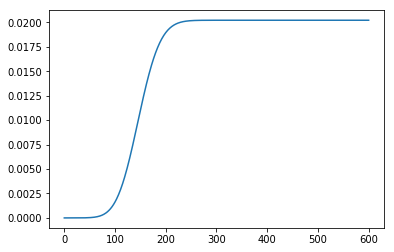

In [14]:
plt.plot(carriers['time'],carriers['dne'])

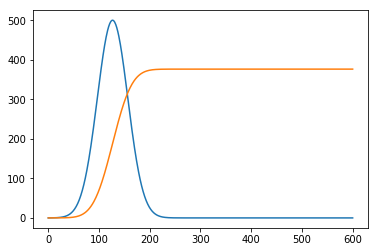

In [15]:
plt.plot(field['time'],field['Intensity'])
plt.plot(field['time'],10*field['Fluence'])

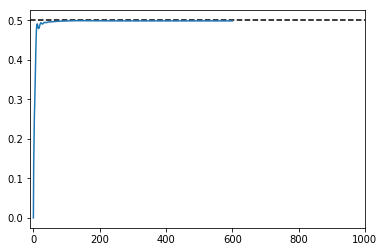

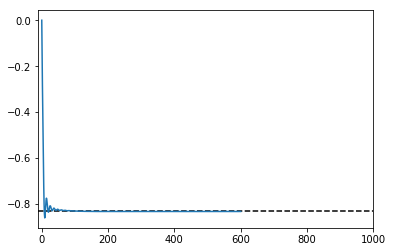

In [16]:
plt.plot(spin['time'],spin['Mc_z'])
plt.hlines(0.5,-10,1100,linestyles='--')
plt.xlim(-10,1000)
plt.show()

plt.plot(spin['time'],spin['Mv_z'])
plt.hlines(-0.83,-10,1100,linestyles='--')
plt.xlim(-10,1000)
plt.show()


In [17]:
spin['Mc_z'][100]

0.4984034

### RT computation for a single kpoint 

We analyze the case of a single kpoint close to $\Gamma$ but outside the high symmetry directions

We tune the frequency of the pump at the value average gap of this point. We also reduce the damping and increase
the simulation time to be able to study the time dynamics of the signal

In [22]:
field_freq = 2.15
sim_time = 4000 

rt_input.set_rt_field(int=field_int,width=field_width,polarization=field_pol,freq=field_freq)
rt_input.set_rt_simulationTimes(sim_time=sim_time,time_units='fs',time_step=time_step)
rt_input

{'args': 'yambo_rt -n p -v ip -V rt',
 'arguments': ['life', 'negf', 'DephCVonly'],
 'filename': 'yambo.in',
 'folder': 'RT_1k-nosym/FixSymm',
 'variables': {'DBsIOoff': 'carriers obs',
  'DephEThresh': [0.0002721, 'eV'],
  'DephMatrix': [[1, 1, 1, '-1.00000'], ''],
  'FFTGvecs': [3527.0, 'RL'],
  'Field1_DFreq': [0.0, 'eV'],
  'Field1_Dir': [[1.0, 0.0, 0.0], ''],
  'Field1_Dir_circ': [[0.0, 1.0, 0.0], ''],
  'Field1_FWHM': [100, 'fs'],
  'Field1_Freq': [[2.15, 2.15], 'eV'],
  'Field1_Int': [1000.0, 'kWLm2'],
  'Field1_Tstart': [0.0, 'fs'],
  'Field1_Width': [0.0, 'fs'],
  'Field1_kind': 'QSSIN',
  'Field1_pol': 'circular',
  'GfnQP_E': [[0.5467, 1.0, 1.0], ''],
  'GfnQP_Wc': [[0.002, 0.0, 0.0], ''],
  'GfnQP_Wv': [[0.002, 0.0, 0.0], ''],
  'GfnRT_N': [1.0, ''],
  'GfnRTdb': 'none',
  'GrKind': 'HS',
  'HXC_Potential': 'IP',
  'IOCachetime': [2.0, 'fs'],
  'IOtime': [[1.0, 5.0, 1.0], 'fs'],
  'Integrator': 'RK2',
  'NETime': [4000, 'fs'],
  'PhLifeTime': [0.0, 'fs'],
  'RADLifeTime': [

In [23]:
idd = {'simTime':sim_time,'dephase':deph_val,'int':field_int,'freq':field_freq}
name = D.name_from_id(idd)
name

'dephase_0.002-freq_2.15-int_1000.0-simTime_4000'

In [24]:
result = code.run(inputs=[rt_input],names=[name],run_dir=rt_run_dir)
result

Skip the computation for input dephase_0.002-freq_2.15-int_1000.0-simTime_4000
Job completed


{'dbs': ['RT_1k-nosym/FixSymm/dephase_0.002-freq_2.15-int_1000.0-simTime_4000'],
 'output': [['RT_1k-nosym/FixSymm/dephase_0.002-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.002-freq_2.15-int_1000.0-simTime_4000.orbt_magnetization',
   'RT_1k-nosym/FixSymm/dephase_0.002-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.002-freq_2.15-int_1000.0-simTime_4000.spin_magnetization',
   'RT_1k-nosym/FixSymm/dephase_0.002-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.002-freq_2.15-int_1000.0-simTime_4000.carriers',
   'RT_1k-nosym/FixSymm/dephase_0.002-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.002-freq_2.15-int_1000.0-simTime_4000.current',
   'RT_1k-nosym/FixSymm/dephase_0.002-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.002-freq_2.15-int_1000.0-simTime_4000.polarization',
   'RT_1k-nosym/FixSymm/dephase_0.002-freq_2.15-int_1000.0-simTime_4000/o-dephase_0.002-freq_2.15-int_1000.0-simTime_4000.external_field']]}

In [25]:
data = P.YamboParser(result['output'][0])
data.keys()

dict_keys(['polarization', 'carriers', 'spin_magnetization', 'orbt_magnetization', 'external_field', 'current'])

In [26]:
field = data['external_field']
carriers = data['carriers']
spin = data['spin_magnetization']

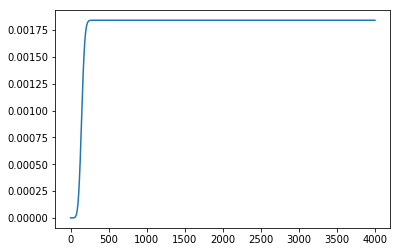

In [27]:
plt.plot(carriers['time'],carriers['dne'])

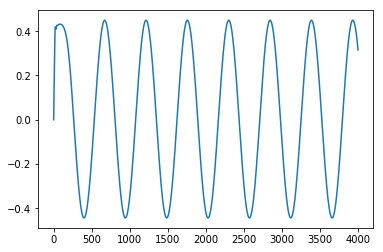

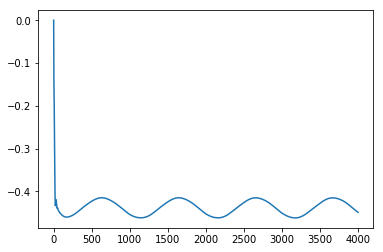

In [28]:
plt.plot(spin['time'],spin['Mc_z'])
plt.show()

plt.plot(spin['time'],spin['Mv_z'])
plt.show()

We can measure the frequency of the oscillations

In [29]:
time = spin['time']
mgn = spin['Mc_z']

In [30]:
from scipy.signal import argrelextrema

In [31]:
t_max = time[argrelextrema(mgn, np.greater)[0]]
t_max

array([  22.,   44.,   85.,  671., 1214., 1757., 2301., 2844., 3388.,
       3931.])

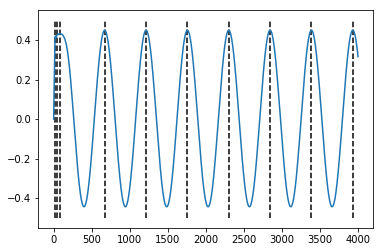

In [32]:
plt.plot(spin['time'],spin['Mc_z'])
for t in t_max:
    plt.vlines(t,-0.5,0.5,linestyles='--')
plt.show()

In [33]:
deltaT = []
for ind in range(len(t_max)-1):
    deltaT.append(t_max[ind+1]-t_max[ind])
deltaT

[22.0, 41.0, 586.0, 543.0, 543.0, 544.0, 543.0, 544.0, 543.0]

In [34]:
nu = 1./544
e = U.Planck_ev_ps*1e6*nu # 1e6 convert in meV*fs
e

7.602330323529411

__The frequency after the transient exactly matches with the energy difference between c and c' conduction bands!__

We can also measure the frequency of the oscillations for valence magnetization

In [35]:
time = spin['time']
mgn = spin['Mv_z']

In [36]:
t_max = time[argrelextrema(mgn, np.greater)[0]]
t_max

array([  31.,   50.,  173.,  631., 1643., 2158., 2164., 2171., 2654.,
       3668.])

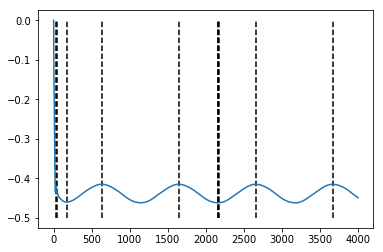

In [38]:
plt.plot(time,mgn)
for t in t_max:
    plt.vlines(t,-0.5,0.,linestyles='--')
plt.show()

In [39]:
deltaT = []
for ind in range(len(t_max)-1):
    deltaT.append(t_max[ind+1]-t_max[ind])
deltaT

[19.0, 123.0, 458.0, 1012.0, 515.0, 6.0, 7.0, 483.0, 1014.0]

In [40]:
nu = 1./1014
e = U.Planck_ev_ps*1e6*nu # 1e6 convert in meV*fs
e

4.078567747534517

Which is its meaning?

### RT computation for kpoints sampling close to $\Gamma$.

We analyze the cases of 50 and 100 random kpoint sampled around to $\Gamma$.

We tune the frequency of the pump at the 1.5 where there is the maximum of the cv JDos.

In [9]:
bands = [5,10] # split-off bands are not relevant for this analysis
field_freq = 1.5
time_step = 20 #as
sim_time = 10000
deph_val  = 0.002 #0.0001
deph_cond = deph_val 
field_width = 200 #fs

rt_input.set_rt_field(int=field_int,width=field_width,polarization=field_pol,freq=field_freq)
rt_input.set_rt_bands(bands=bands,scissor=scissor,damping_valence=deph_val,damping_conduction=deph_cond)
rt_input.set_rt_simulationTimes(sim_time=sim_time,time_units='fs',time_step=time_step)

# we test the adapative RTstep options 
rt_input['variables']['dTupdateTime'] = [1000,'fs']
rt_input['variables']['dTupdateJump'] = [10.0,'fs']
rt_input['variables']['dTupdateTresh'] = [0.1,'']
rt_input['variables']['dT_MAX'] = [50,'as']

rt_input

{'args': 'yambo_rt -n p -v ip -V rt',
 'arguments': ['life', 'negf', 'DephCVonly'],
 'filename': 'yambo.in',
 'folder': 'RT_k50/FixSymm',
 'variables': {'DBsIOoff': 'carriers obs',
  'DephEThresh': [0.0002721, 'eV'],
  'DephMatrix': [[1, 1, 1, '-1.00000'], ''],
  'FFTGvecs': [3479.0, 'RL'],
  'Field1_DFreq': [0.0, 'eV'],
  'Field1_Dir': [[1.0, 0.0, 0.0], ''],
  'Field1_Dir_circ': [[0.0, 1.0, 0.0], ''],
  'Field1_FWHM': [200, 'fs'],
  'Field1_Freq': [[1.5, 1.5], 'eV'],
  'Field1_Int': [1000.0, 'kWLm2'],
  'Field1_Tstart': [0.0, 'fs'],
  'Field1_Width': [0.0, 'fs'],
  'Field1_kind': 'QSSIN',
  'Field1_pol': 'circular',
  'GfnQP_E': [[0.5467, 1.0, 1.0], ''],
  'GfnQP_Wc': [[0.002, 0.0, 0.0], ''],
  'GfnQP_Wv': [[0.002, 0.0, 0.0], ''],
  'GfnRT_N': [1.0, ''],
  'GfnRTdb': 'none',
  'GrKind': 'HS',
  'HXC_Potential': 'IP',
  'IOCachetime': [2.0, 'fs'],
  'IOtime': [[1.0, 5.0, 1.0], 'fs'],
  'Integrator': 'RK2',
  'NETime': [10000, 'fs'],
  'PhLifeTime': [0.0, 'fs'],
  'RADLifeTime': [0.0, '

In [10]:
idd = {'simTime':sim_time,'dephase':deph_val,'int':field_int,'freq':field_freq}
name = D.name_from_id(idd)+'-fwhm_200'
name

'dephase_0.002-freq_1.5-int_1000.0-simTime_10000-fwhm_200'

In [11]:
result = code.run(inputs=[rt_input],names=[name],run_dir=rt_run_dir)

Executing command: cd RT_k50/FixSymm; mpirun -np 32 yambo_rt -F dephase_0.002-freq_1.5-int_1000.0-simTime_10000-fwhm_200.in -J dephase_0.002-freq_1.5-int_1000.0-simTime_10000-fwhm_200 -C dephase_0.002-freq_1.5-int_1000.0-simTime_10000-fwhm_200
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True

In [12]:
data = P.YamboParser(result['output'][0])
data.keys()

dict_keys(['orbt_magnetization', 'external_field', 'current', 'spin_magnetization', 'polarization', 'carriers'])

In [13]:
field = data['external_field']
carriers = data['carriers']
spin = data['spin_magnetization']

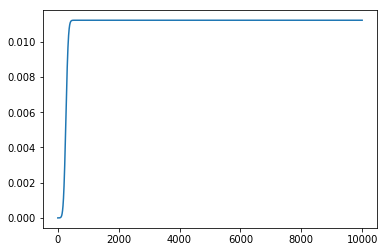

In [14]:
plt.plot(carriers['time'],carriers['dne'])

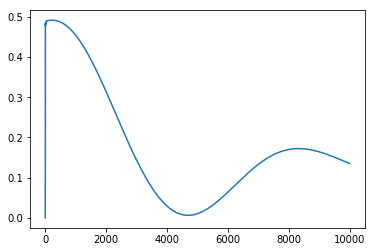

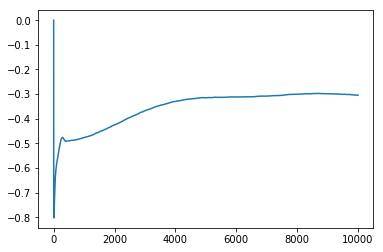

In [15]:
plt.plot(spin['time'],spin['Mc_z'])
plt.show()

plt.plot(spin['time'],spin['Mv_z'])
plt.show()

### RT computation for 100 random kpoints (in a k area with energies up to 2 eV)

We analyze the case of a 100 random kpoints.

We tune the frequency of the pump at the 1.55 where the absorption should be very high. We also reduce the damping and increase
the simulation time to be able to study the time dynamics of the signal

In [ ]:
field_freq = 1.55
sim_time = 6000 

rt_input.set_rt_field(int=field_int,width=field_width,polarization=field_pol,freq=field_freq)
rt_input.set_rt_simulationTimes(sim_time=sim_time,time_units='fs',time_step=time_step)
rt_input

In [ ]:
idd = {'simTime':sim_time,'dephase':deph_val,'int':field_int,'freq':field_freq}
name = D.name_from_id(idd)
name

In [ ]:
result = code.run(inputs=[rt_input],names=[name],run_dir=rt_run_dir)

In [ ]:
data = P.YamboParser(result['output'][0])
data.keys()

In [ ]:
field = data['external_field']
carriers = data['carriers']
spin = data['spin_magnetization']

In [ ]:
plt.plot(carriers['time'],carriers['dne'])

In [ ]:
plt.plot(spin['time'],spin['Mc_z'])
plt.show()

plt.plot(spin['time'],spin['Mv_z'])
plt.show()

In [ ]:
time = spin['time']
mgn = spin['Mc_z']

In [ ]:
from scipy.signal import argrelextrema

In [ ]:
t_max = time[argrelextrema(mgn, np.less)[0]]
t_max

In [ ]:
plt.plot(spin['time'],spin['Mc_z'])
for t in t_max:
    plt.vlines(t,-0.2,0.5,linestyles='--')
plt.show()

In [ ]:
deltaT = []
for ind in range(len(t_max)-1):
    deltaT.append(t_max[ind+1]-t_max[ind])
deltaT

In [ ]:
nu = 1./2726
e = U.Planck_ev_ps*1e6*nu # 1e6 convert in meV*fs
e